<a href="https://colab.research.google.com/github/Sr-Conde-Killer-Noxius/Quantum-Minds/blob/main/Backtest_Baseline_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip -q install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

In [48]:
# CÉLULA 2: Universo (Corrigida)
from datetime import datetime, timedelta

# Período: últimos 3 anos
end_dt = datetime.today().date() - timedelta(days=1) # D-1
start_dt = end_dt - timedelta(days=365*3)

end_date = end_dt.strftime('%Y-%m-%d')
start_date = start_dt.strftime('%Y-%m-%d')

# Universo (Ações B3 Agro/Proteínas):
TICKERS = [
    "SLCE3.SA", "AGRO3.SA", "SMTO3.SA",
    "CSAN3.SA", "BRFS3.SA", "MRFG3.SA",
    "BEEF3.SA", "SOJA3.SA", "KEPL3.SA",
    "FHER3.SA"
]

# Benchmarks
IBOV_TICKER = "^BVSP"
IAGRO_TICKER = "AGRI11.SA" # (ETF que replica o IAGRO B3)

In [49]:
# CÉLULA 3: Download ou Geração de Dados (Completa e Corrigida)
# Usando as datas string da Célula 2

all_data = {}
failed_tickers_map = {}

print(f"Baixando dados de {start_date} até {end_date}...")
print("Tentando baixar tickers individuais (Modo Robusto v5.5)...")
for ticker in TICKERS:
    try:
        tk = yf.Ticker(ticker)
        # yfinance lida melhor com strings de data
        data = tk.history(start=start_date, end=end_date)

        if data.empty or 'Close' not in data.columns or data['Close'].isnull().all():
            raise Exception("Dados vazios ou coluna 'Close' ausente/NaN.")

        close_prices = data['Close']
        all_data[ticker] = close_prices
        print(f"  [OK] {ticker}")

    except Exception as e:
        print(f"  [FALHA] {ticker}: {e}")
        failed_tickers_map[ticker] = str(e)

if all_data:
    prices_df = pd.DataFrame(all_data)
    prices_df = prices_df[sorted(prices_df.columns)]
else:
    prices_df = pd.DataFrame(columns=TICKERS)

try:
    print("\nBaixando benchmarks...")
    ibov_data = yf.Ticker(IBOV_TICKER).history(start=start_date, end=end_date)['Close']
    iagro_data = yf.Ticker(IAGRO_TICKER).history(start=start_date, end=end_date)['Close']

    available_tickers = sorted(list(prices_df.columns))
    failed_tickers = sorted(list(failed_tickers_map.keys()))

    print(f"\nAções consideradas (download OK): {available_tickers}")
    if failed_tickers:
        print(f"Tickers com falha no download (ignorados): {failed_tickers}")
        for t in failed_tickers:
           if t in failed_tickers_map:
               error_msg = str(failed_tickers_map[t]).split('\n')[0]
               print(f"    - {t} (Motivo): {error_msg}")

    MIN_STOCKS = 1
    if prices_df.empty or len(available_tickers) < MIN_STOCKS:
        raise Exception("Nenhum dado real pôde ser baixado.")

    ibov_data.name = "IBOV"
    iagro_data.name = "IAGRO"

    available_benchmarks_list = []
    if not ibov_data.empty:
        available_benchmarks_list.append(ibov_data)
    if not iagro_data.empty:
        available_benchmarks_list.append(iagro_data)

    print(f"Benchmarks disponíveis: {[b.name for b in available_benchmarks_list]}")

    if available_benchmarks_list:
        prices_df = prices_df.join(available_benchmarks_list, how='outer')

    prices_df.index = prices_df.index.tz_convert(None).normalize()

    if 'IBOV' in prices_df:
        prices_df = prices_df[prices_df['IBOV'].notna()]
    else:
        prices_df = prices_df.dropna(subset=available_tickers, how='all')

    prices_df[available_tickers] = prices_df[available_tickers].ffill()

    if 'IAGRO' in prices_df:
        prices_df['IAGRO'] = prices_df['IAGRO'].ffill()

    prices_df = prices_df.dropna(how='all')

    print(f"Linhas (dias úteis) no período: {len(prices_df)}")

    # 4. Cálculo de Retornos
    returns_df = prices_df.pct_change()

    asset_returns = returns_df[available_tickers]
    benchmark_returns = returns_df[[b.name for b in available_benchmarks_list if b.name in returns_df]]

    # <--- CORREÇÃO AQUI: Linha problemática comentada/removida
    # benchmark_returns = benchmark_returns.dropna(how='all')
    # ^^^^ ESTA LINHA CAUSA O BUG DE 749 vs 748 ^^^^

    # NÃO limpar NaNs dos asset_returns, C4 fará isso com .fillna(0.0)

    print("\nCélula 3 (Download/Preparação de Dados Reais) concluída com sucesso.")

except Exception as e:
    print(f"\nAVISO: Falha no download dos dados reais ({e}).")
    print("Iniciando geração de dados SINTÉTICOS para o backtest.")

    np.random.seed(42)
    n_dias = (end_dt - start_dt).days
    datas_sinteticas = pd.bdate_range(start_dt, periods=n_dias)

    available_tickers = TICKERS
    asset_returns = pd.DataFrame(
        np.random.randn(len(datas_sinteticas), len(available_tickers)) / 100 + 0.0005,
        index=datas_sinteticas,
        columns=available_tickers
    )

    # Adicionando o IAGRO sintético também, para o script não quebrar
    benchmark_returns = pd.DataFrame({
        "IBOV": np.random.randn(len(datas_sinteticas)) / 100 + 0.0003,
        "IAGRO": np.random.randn(len(datas_sinteticas)) / 100 + 0.0004
    }, index=datas_sinteticas)

    print("Dados sintéticos gerados.")

Baixando dados de 2022-11-04 até 2025-11-03...
Tentando baixar tickers individuais (Modo Robusto v5.5)...
  [OK] SLCE3.SA
  [OK] AGRO3.SA
  [OK] SMTO3.SA
  [OK] CSAN3.SA
  [OK] BRFS3.SA
  [OK] MRFG3.SA
  [OK] BEEF3.SA
  [OK] SOJA3.SA
  [OK] KEPL3.SA
  [OK] FHER3.SA

Baixando benchmarks...

Ações consideradas (download OK): ['AGRO3.SA', 'BEEF3.SA', 'BRFS3.SA', 'CSAN3.SA', 'FHER3.SA', 'KEPL3.SA', 'MRFG3.SA', 'SLCE3.SA', 'SMTO3.SA', 'SOJA3.SA']
Benchmarks disponíveis: ['IBOV', 'IAGRO']
Linhas (dias úteis) no período: 749

Célula 3 (Download/Preparação de Dados Reais) concluída com sucesso.


In [50]:
# CÉLULA 4: Cálculo de Retorno Anual (Corrigido v7)
# Método vetorizado (sem .apply) para máxima estabilidade

# 1. Retorno diário (preenchido com 0.0)
ret_assets = asset_returns.fillna(0.0)

# <--- CORREÇÃO FINAL (v7) ----

# 2. Calcular os log-returns de TODO o DataFrame de uma vez
# np.log(1 + 0.0) = 0.0 (seguro)
log_ret_assets = np.log(1 + ret_assets)

# 3. Agrupar os log-returns por ano e SOMAR.
# Esta é uma operação vetorizada e robusta.
log_ret_annual = log_ret_assets.groupby(log_ret_assets.index.year).sum()

# 4. Converter as somas dos log-returns de volta para retornos anuais
ret_annual = np.exp(log_ret_annual) - 1

# ---- FIM DA CORREÇÃO ----

print("Retornos anuais (Ações) (%):")
with pd.option_context('display.float_format', None):
    display(100 * ret_annual)

Retornos anuais (Ações) (%):


,AGRO3.SA,BEEF3.SA,BRFS3.SA,CSAN3.SA,FHER3.SA,KEPL3.SA,MRFG3.SA,SLCE3.SA,SMTO3.SA,SOJA3.SA
Date,,,,,,,,,,
2022,-4.250565,-9.937461,-34.803154,-8.449178,11.419358,-19.096295,-14.670823,-1.013248,-7.003927,-22.351049
2023,-0.228099,-39.295175,66.787440,16.157107,-57.151130,18.635381,12.130009,-5.824917,14.629079,66.401011
2024,-11.652700,-31.860772,88.748894,-56.367893,-16.216220,-7.634382,104.873196,-2.787354,-16.836007,-35.120731
2025,-6.186521,41.060896,-29.219242,-24.632350,-24.032255,7.042115,17.355345,-5.081993,-38.109990,2.425797


In [51]:
# CÉLULA 5: A Seleção (Ranking) (Corrigido)
TOP_N = 5

# Itera sobre o DataFrame de retornos anuais (calculado na Célula 4)
top_by_year = {}

# <--- CORREÇÃO AQUI ----
# O índice de 'ret_annual' agora é o próprio ano (int), não mais um datetime.
# Trocamos 'dt' (que era o datetime) por 'year' (que é o int)
for year, row in ret_annual.iterrows():
    # 'year' já é o ano que queremos (ex: 2022)

    # Ordena do maior para o menor retorno
    ranked = row.dropna().sort_values(ascending=False)

    # Seleciona os TOP_N
    top_n = ranked.head(TOP_N)
    top_by_year[year] = top_n

# ---- FIM DA CORREÇÃO ----

print(f"Ranking dos Top {TOP_N} (por Retorno Anual):")
display(top_by_year)


Ranking dos Top 5 (por Retorno Anual):


{2022: FHER3.SA    0.1142
 SLCE3.SA   -0.0101
 AGRO3.SA   -0.0425
 SMTO3.SA   -0.0700
 CSAN3.SA   -0.0845
 Name: 2022, dtype: float64,
 2023: BRFS3.SA   0.6679
 SOJA3.SA   0.6640
 KEPL3.SA   0.1864
 CSAN3.SA   0.1616
 SMTO3.SA   0.1463
 Name: 2023, dtype: float64,
 2024: MRFG3.SA    1.0487
 BRFS3.SA    0.8875
 SLCE3.SA   -0.0279
 KEPL3.SA   -0.0763
 AGRO3.SA   -0.1165
 Name: 2024, dtype: float64,
 2025: BEEF3.SA    0.4106
 MRFG3.SA    0.1736
 KEPL3.SA    0.0704
 SOJA3.SA    0.0243
 SLCE3.SA   -0.0508
 Name: 2025, dtype: float64}

In [52]:
# CÉLULA 6: Construção da carteira (Completa, com Rebalanceamento MENSAL)

# --- Cálculo do Baseline ---
print("Calculando Baseline (Rebalanceamento Anual/Mensal)...")
baseline_ret = pd.Series(index=asset_returns.index, dtype=float)
years = sorted(set(d.year for d in asset_returns.index))

for y in years:
    mask = asset_returns.index.year == y
    if y not in top_by_year: # top_by_year vem da Célula 5
        baseline_ret.loc[mask] = np.nan
        continue

    # Pega os 'picks' do ano ANTERIOR para aplicar no ano 'y'
    year_to_use_for_ranking = y - 1
    if year_to_use_for_ranking not in top_by_year:
         baseline_ret.loc[mask] = np.nan
         continue

    # 'picks' agora são as Top 5 (ou o N que vc escolheu)
    picks = [t for t in top_by_year[year_to_use_for_ranking].index if t in asset_returns.columns]
    if len(picks) == 0:
        baseline_ret.loc[mask] = np.nan
        continue

    # --- LÓGICA DE REBALANCEAMENTO MENSAL (Baseline) ---
    # 1. Pega os retornos do ano 'y' para os 'picks' selecionados
    current_year_returns = asset_returns.loc[mask, picks]
    if current_year_returns.empty:
        baseline_ret.loc[mask] = np.nan
        continue

    # 2. Agrupa os retornos por (Ano, Mês)
    monthly_grouper_bl = [current_year_returns.index.year, current_year_returns.index.month]

    # 3. Calcula o cumprod DENTRO de cada mês (reseta todo mês)
    #    Isso simula o "buy and hold" intra-mês
    monthly_intra_cumprod_bl = (1 + current_year_returns.fillna(0.0)).groupby(monthly_grouper_bl).cumprod()

    # 4. Calcula o valor da carteira (média das curvas individuais)
    #    Isso simula o portfólio equal-weight
    portfolio_curve_bl = monthly_intra_cumprod_bl.mean(axis=1)

    # 5. Pega o retorno diário dessa carteira (que rebalanceia mensalmente)
    daily_returns_for_year = portfolio_curve_bl.pct_change()

    # Atribui os retornos diários calculados ao Series principal
    baseline_ret.loc[mask] = daily_returns_for_year
    # --- FIM DA LÓGICA MENSAL ---

# Preencher TODOS os NaNs (iniciais do pct_change e anos sem dados) com 0.0
baseline_ret = baseline_ret.fillna(0.0)
baseline_curve = (1 + baseline_ret).cumprod()
baseline_curve.name = "Baseline"

# --- Cálculo do Agro Proxy (Rebalanceamento MENSAL) ---
print("Calculando Agro Proxy (Rebalanceamento Mensal)...")

# 1. Agrupa os retornos de TODAS as ações por (Ano, Mês)
monthly_grouper_ap = [asset_returns.index.year, asset_returns.index.month]

# 2. Calcula o cumprod DENTRO de cada mês (reseta todo mês)
monthly_intra_cumprod_ap = (1 + asset_returns.fillna(0.0)).groupby(monthly_grouper_ap).cumprod()

# 3. Calcula o valor da carteira (média das curvas individuais)
portfolio_curve_ap = monthly_intra_cumprod_ap.mean(axis=1)

# 4. Pega o retorno diário dessa carteira
agro_proxy_ret = portfolio_curve_ap.pct_change()

# Preencher o NaN inicial (do 1o dia) com 0.0
agro_proxy_ret = agro_proxy_ret.fillna(0.0)
agro_proxy_curve = (1 + agro_proxy_ret).cumprod()
agro_proxy_curve.name = "Agro Proxy"
# --- FIM DA LÓGICA MENSAL ---


# --- Cálculo do Ibovespa (Buy and Hold) ---
ibov_ret = benchmark_returns["IBOV"]
ibov_ret = ibov_ret.fillna(0.0)
ibov_curve = (1 + ibov_ret).cumprod()
ibov_curve = ibov_curve / ibov_curve.iloc[0]
ibov_curve.name = "Ibovespa"

# --- Cálculo do IAGRO (Buy and Hold) ---
if "IAGRO" in benchmark_returns.columns:
    iagro_ret = benchmark_returns["IAGRO"]
    if iagro_ret.isnull().all():
        print("Aviso: Nenhum dado válido encontrado para IAGRO (benchmark). Ignorando IAGRO.")
        iagro_curve = None
    else:
        iagro_ret_filled = iagro_ret.fillna(0.0)
        iagro_curve = (1 + iagro_ret_filled).cumprod()
        iagro_curve = iagro_curve / iagro_curve.iloc[0]
        iagro_curve.name = "IAGRO"
else:
    iagro_curve = None

# --- Checagem de Tamanhos ---
print("Checagem de tamanhos (Rebalanceamento Mensal):")
print("Baseline:", len(baseline_curve))
print("Agro Proxy:", len(agro_proxy_curve))
print("Ibovespa:", len(ibov_curve))
if iagro_curve is not None:
    print("IAGRO:", len(iagro_curve))
else:
    print("IAGRO: Ignorado (dados ausentes)")

# --- Preparar dados para Célula 7 (Métricas) ---
curves_to_analyze = [baseline_curve, agro_proxy_curve, ibov_curve]
if iagro_curve is not None:
    curves_to_analyze.append(iagro_curve)

# Alinhamento final
aligned_curves_df = pd.concat(curves_to_analyze, axis=1)
aligned_curves_df = aligned_curves_df.ffill().dropna()

# Extrair as curvas alinhadas de volta
baseline_curve_aligned = aligned_curves_df["Baseline"]
agro_proxy_curve_aligned = aligned_curves_df["Agro Proxy"]
ibov_curve_aligned = aligned_curves_df["Ibovespa"]
iagro_curve_aligned = aligned_curves_df.get("IAGRO", None)

Calculando Baseline (Rebalanceamento Anual/Mensal)...
Calculando Agro Proxy (Rebalanceamento Mensal)...
Checagem de tamanhos (Rebalanceamento Mensal):
Baseline: 749
Agro Proxy: 749
Ibovespa: 749
IAGRO: 749


In [53]:
# CÉLULA 7: Métricas

import pandas as pd
import numpy as np

def max_drawdown(series: pd.Series) -> float:
    """Máx. queda percentual do pico ao vale."""
    cummax = series.cummax()
    dd = (series / cummax) - 1.0
    return dd.min()

def perf_table(curve: pd.Series, label: str) -> dict:
    """Calcula métricas básicas a partir da curva (base 1)."""
    # Retorno diário a partir da curva
    r = curve.pct_change().dropna()
    if len(r) == 0:
        return {"Label": label, "CAGR": np.nan, "Vol(ann)": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}

    days = (curve.index[-1] - curve.index[0]).days
    years = days / 365.0 if days > 0 else np.nan

    # CAGR
    cagr = curve.iloc[-1] ** (1/years) - 1 if years and years > 0 else np.nan
    # Vol anual (assumindo 252 pregões)
    vol_ann = r.std() * np.sqrt(252)
    # Sharpe simples (rf=0)
    sharpe = (r.mean() * 252) / vol_ann if vol_ann and vol_ann > 0 else np.nan
    # Máx Drawdown
    mdd = max_drawdown(curve)

    return {"Label": label,
            "CAGR": cagr,
            "Vol(ann)": vol_ann,
            "Sharpe": sharpe,
            "MaxDD": mdd}

# --- MUDANÇA PRINCIPAL AQUI ---
# Monta uma tabela com as curvas ALINHADAS (da Célula 6)
curves = [baseline_curve_aligned, agro_proxy_curve_aligned, ibov_curve_aligned]

# Adiciona a curva IAGRO se ela foi calculada com sucesso na Célula 6
if iagro_curve_aligned is not None:
     curves.append(iagro_curve_aligned)
# --- FIM DA MUDANÇA ---

rows = [perf_table(c, c.name) for c in curves]
perf_df = pd.DataFrame(rows).set_index("Label")
display((100*perf_df[["CAGR","Vol(ann)","Sharpe","MaxDD"]]).round(2).rename(columns={
    "CAGR":"CAGR (%)", "Vol(ann)":"Vol (ann, %)", "Sharpe":"Sharpe (x100)", "MaxDD":"MaxDD (%)"
}))

,CAGR (%),"Vol (ann, %)",Sharpe (x100),MaxDD (%)
Label,,,,
Baseline,1.9200,27.8600,20.5900,-24.6800
Agro Proxy,0.6000,29.5600,16.6400,-25.1600
Ibovespa,8.1900,15.7600,58.2400,-17.1200
IAGRO,-6.5900,18.5700,-27.7400,-24.4500


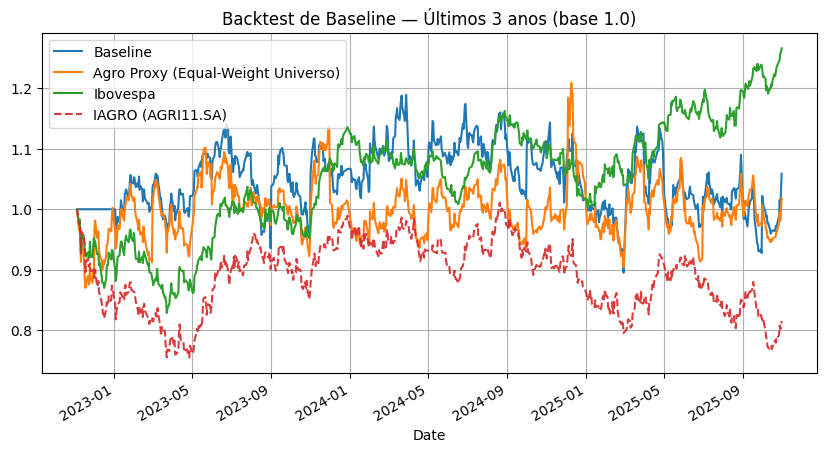

In [54]:
# CÉLULA 8: Gráfico

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# <--- MUDANÇA (Usar curvas alinhadas para plotagem)
baseline_curve_aligned.plot(label="Baseline")
agro_proxy_curve_aligned.plot(label="Agro Proxy (Equal-Weight Universo)")
ibov_curve_aligned.plot(label="Ibovespa")

# <--- ADIÇÃO (Plotar o IAGRO se ele existir)
if iagro_curve_aligned is not None:
    iagro_curve_aligned.plot(label="IAGRO (AGRI11.SA)", linestyle='--', alpha=0.9)
# --- FIM DAS MUDANÇAS ---

plt.title("Backtest de Baseline — Últimos 3 anos (base 1.0)")
plt.legend()
plt.grid(True)
plt.show()